# Multitask Regression/Classification Network State Reconstruction Demo

## Install libraries to runtime

If running in Google Colab, run the following setup cell once each time you open your project in order to install non-default package dependencies to the runtime. DO NOT RUN if you have already created a kernel with `qsttoolkit` as per the setup instructions in `README.md`.

In [ ]:
!pip install qsttoolkit

## Imports

All of QSTToolkit's features can be accessed by importing `qsttoolkit` and calling them directly. Most features sit within two main subpackages: `.data` and `.tomography`. In this example notebook, functions are called from their subpackage where relevant to show which features sit in each subpackage, and which lie in modules outside either:

In [1]:
from google.colab import drive
drive.mount('/content/drive')
!pip install -r /content/drive/MyDrive/Google_Colab/requirements.txt
%cd /content/drive/MyDrive/Google_Colab

Mounted at /content/drive
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.1/30.1 MB 58.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 87.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.1/121.1 kB 12.7 MB/s eta 0:00:00
/content/drive/MyDrive/Google_Colab


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import qutip as qt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf

import qsttoolkit as qst

## Data Preparation

We first create batches of optical quantum state vectors of seven different varieties. `qsttoolkit.data` provides classes to produce such batches, each state with randomized parameters within given limits, based on the [QuTiP](https://qutip.org/docs/4.0.2/index.html) framework:

In [3]:
dim = 32            # Dimensionality of the Hilbert space of the system

fock_batch = qst.data.FockStates(n_states = 1000,
                                 dim = dim,
                                 n_range = [0, dim])
coherent_batch = qst.data.CoherentStates(n_states = 1000,
                                         dim = dim,
                                         alpha_magnitude_range = [1e-6, 3])
thermal_batch = qst.data.ThermalStates(n_states = 1000,
                                       dim = dim,
                                       nbar_range = [0, dim])
num_batch = qst.data.NumStates(n_states = 1000,
                               dim = dim,
                               types = ['17', 'M', 'P', 'P2', 'M2'])
binomial_batch = qst.data.BinomialStates(n_states = 1000,
                                         dim = dim,
                                         S_range = [1, 10],
                                         mu_range = [0, 2])
cat_batch = qst.data.CatStates(n_states = 1000,
                               dim = dim,
                               alpha_magnitude_range = [0, 10])
random_batch = qst.data.RandomStates(n_states = 1000,
                                     dim = dim)

print('States generated')

/content/drive/MyDrive/Google_Colab/qsttoolkit/data/state_batches.py:174: UserWarning: thermal states are currently initialized as density matrices. Calling the product of the .density_matrices() method is equivalent to simply calling .states() attribute. This may change in the future.
  warnings.warn("thermal states are currently initialized as density matrices. Calling the product of the .density_matrices() method is equivalent to simply calling .states() attribute. This may change in the future.")


States generated


/content/drive/MyDrive/Google_Colab/qsttoolkit/data/state_batches.py:369: UserWarning: Random states are currently initialized as density matrices. Calling the product of the .density_matrices() method is equivalent to simply calling .states() attribute. This may change in the future.
  warnings.warn("Random states are currently initialized as density matrices. Calling the product of the .density_matrices() method is equivalent to simply calling .states() attribute. This may change in the future.")


Parameters for noise sources that are applied to the density matrix and Husimi Q data:

In [4]:
mixed_state_noise_level = 0.2         # Mixed state noise coefficient
Gaussian_conv_ntherm = 2.0            # Variance of the Gaussian convolution kernel
affine_theta = 20.0                   # Maximum affine transformation theta
affine_x = 0.1                        # Maximum affine transformation x shift
affine_y = 0.1                        # Maximum affine transformation y shift
additive_Gaussian_stddev = 0.01      # Additive Gaussian noise distribution standard deviation
pepper_p = 0.01                       # Pepper noise pixel probability
salt_p = 0.0                          # Salt noise pixel probability

We initialize the Husimi Q phase space before creating measurement data:

In [5]:
data_dim = 32                 # Dimensions of the phase space grid that will serve as the image size for our data
xgrid = np.linspace(-5, 5, data_dim)
pgrid = np.linspace(-5, 5, data_dim)

We then create density matrices and Husimi Q measurement images, applying mixed state noise using `qsttoolkit.data.mixed_state_noise()`, amplification noise using `qsttoolkit.data.gaussian_convolution()` and measurement noise using `qsttoolkit.data.apply_measurement_noise()`:

In [6]:
fock_data = pd.DataFrame(columns=['label', 'density_matrix', 'Husimi-Q_function', 'state_parameter'])
coherent_data = pd.DataFrame(columns=['label', 'density_matrix', 'Husimi-Q_function', 'state_parameter'])
thermal_data = pd.DataFrame(columns=['label', 'density_matrix', 'Husimi-Q_function', 'state_parameter'])
num_data = pd.DataFrame(columns=['label', 'density_matrix', 'Husimi-Q_function', 'state_parameter'])
binomial_data = pd.DataFrame(columns=['label', 'density_matrix', 'Husimi-Q_function', 'state_parameter'])
cat_data = pd.DataFrame(columns=['label', 'density_matrix', 'Husimi-Q_function', 'state_parameter'])
random_data = pd.DataFrame(columns=['label', 'density_matrix', 'Husimi-Q_function', 'state_parameter'])
print("DataFrames initialized")

fock_densities = [qst.mixed_state_noise(dm, mixed_state_noise_level) for dm in fock_batch.density_matrices()]
fock_data['label'] = ['fock']*len(fock_densities)
fock_data['density_matrix'] = [dm.full() for dm in fock_densities]
fock_data['Husimi-Q_function'] = [qst.apply_measurement_noise(qst.gaussian_convolution(qt.qfunc(dm, xgrid, pgrid), Gaussian_conv_ntherm), affine_theta, affine_x, affine_y, additive_Gaussian_stddev, pepper_p, salt_p) for dm in fock_densities]
fock_data['state_parameter'] = fock_batch.params
print("Fock data generated")

coherent_densities = [qst.mixed_state_noise(dm, mixed_state_noise_level) for dm in coherent_batch.density_matrices()]
coherent_data['label'] = ['coherent']*len(coherent_densities)
coherent_data['density_matrix'] = [dm.full() for dm in coherent_densities]
coherent_data['Husimi-Q_function'] = [qst.apply_measurement_noise(qst.gaussian_convolution(qt.qfunc(dm, xgrid, pgrid), Gaussian_conv_ntherm), affine_theta, affine_x, affine_y, additive_Gaussian_stddev, pepper_p, salt_p) for dm in coherent_densities]
coherent_data['state_parameter'] = coherent_batch.params
print("Coherent data generated")

thermal_densities = [qst.mixed_state_noise(dm, mixed_state_noise_level) for dm in thermal_batch.density_matrices()]
thermal_data['label'] = ['thermal']*len(thermal_densities)
thermal_data['density_matrix'] = [dm.full() for dm in thermal_densities]
thermal_data['Husimi-Q_function'] = [qst.apply_measurement_noise(qst.gaussian_convolution(qt.qfunc(dm, xgrid, pgrid), Gaussian_conv_ntherm), affine_theta, affine_x, affine_y, additive_Gaussian_stddev, pepper_p, salt_p) for dm in thermal_densities]
thermal_data['state_parameter'] = thermal_batch.params
print("Thermal data generated")

num_densities = [qst.mixed_state_noise(dm, mixed_state_noise_level) for dm in num_batch.density_matrices()]
num_data['label'] = ['num']*len(num_densities)
num_data['density_matrix'] = [dm.full() for dm in num_densities]
num_data['Husimi-Q_function'] = [qst.apply_measurement_noise(qst.gaussian_convolution(qt.qfunc(dm, xgrid, pgrid), Gaussian_conv_ntherm), affine_theta, affine_x, affine_y, additive_Gaussian_stddev, pepper_p, salt_p) for dm in num_densities]
num_data['state_parameter'] = num_batch.params
print("Num data generated")

binomial_densities = [qst.mixed_state_noise(dm, mixed_state_noise_level) for dm in binomial_batch.density_matrices()]
binomial_data['label'] = ['binomial']*len(binomial_densities)
binomial_data['density_matrix'] = [dm.full() for dm in binomial_densities]
binomial_data['Husimi-Q_function'] = [qst.apply_measurement_noise(qst.gaussian_convolution(qt.qfunc(dm, xgrid, pgrid), Gaussian_conv_ntherm), affine_theta, affine_x, affine_y, additive_Gaussian_stddev, pepper_p, salt_p) for dm in binomial_densities]
binomial_data['state_parameter'] = binomial_batch.params
print("Binomial data generated")

cat_densities = [qst.mixed_state_noise(dm, mixed_state_noise_level) for dm in cat_batch.density_matrices()]
cat_data['label'] = ['cat']*len(cat_densities)
cat_data['density_matrix'] = [dm.full() for dm in cat_densities]
cat_data['Husimi-Q_function'] = [qst.apply_measurement_noise(qst.gaussian_convolution(qt.qfunc(dm, xgrid, pgrid), Gaussian_conv_ntherm), affine_theta, affine_x, affine_y, additive_Gaussian_stddev, pepper_p, salt_p) for dm in cat_densities]
cat_data['state_parameter'] = cat_batch.params
print("Cat data generated")

random_densities = [qst.mixed_state_noise(dm, mixed_state_noise_level) for dm in random_batch.density_matrices()]
random_data['label'] = ['random']*len(random_densities)
random_data['density_matrix'] = [dm.full() for dm in random_densities]
random_data['Husimi-Q_function'] = [qst.apply_measurement_noise(qst.gaussian_convolution(qt.qfunc(dm, xgrid, pgrid), Gaussian_conv_ntherm), affine_theta, affine_x, affine_y, additive_Gaussian_stddev, pepper_p, salt_p) for dm in random_densities]
random_data['state_parameter'] = random_batch.params
print("Random data generated")

data = pd.concat([fock_data, coherent_data, thermal_data, num_data, binomial_data, cat_data, random_data])
data = data.sample(frac=1).reset_index(drop=True)
print("Dataset generated")

DataFrames initialized
Fock data generated
Coherent data generated
Thermal data generated
Num data generated
Binomial data generated
Cat data generated
Random data generated
Dataset generated


Alternatively, QSTToolkit provides `optical_state_dataset()` which produces the above dataset in one function, intended to be used as a standardized dataset for training models. All the implemented noise sources are applied to the generated data, with levels that can be adjusted in the arguments:

In [7]:
data = qst.data.optical_state_dataset(dim=32,
                                      data_dim=32,
                                      state_numbers=[1000, 1000, 1000, 1000, 1000, 1000, 0, 1000],       # Large numbers of GKP states take an intractable amount of time to produce, and are difficult to produce practically
                                      mixed_state_noise_level = 0.2,
                                      Gaussian_conv_ntherm = 2.0,
                                      affine_theta = 20.0,
                                      affine_x = 0.1,
                                      affine_y = 0.1,
                                      additive_Gaussian_stddev = 0.01,
                                      pepper_p = 0.01,
                                      salt_p = 0.0)

Fock states generated
Coherent states generated
Thermal states generated
Num states generated


/content/drive/MyDrive/Google_Colab/qsttoolkit/data/state_batches.py:174: UserWarning: thermal states are currently initialized as density matrices. Calling the product of the .density_matrices() method is equivalent to simply calling .states() attribute. This may change in the future.
  warnings.warn("thermal states are currently initialized as density matrices. Calling the product of the .density_matrices() method is equivalent to simply calling .states() attribute. This may change in the future.")


Binomial states generated
Cat states generated
GKP states generated
Random states generated
DataFrames initialized


/content/drive/MyDrive/Google_Colab/qsttoolkit/data/state_batches.py:369: UserWarning: Random states are currently initialized as density matrices. Calling the product of the .density_matrices() method is equivalent to simply calling .states() attribute. This may change in the future.
  warnings.warn("Random states are currently initialized as density matrices. Calling the product of the .density_matrices() method is equivalent to simply calling .states() attribute. This may change in the future.")
<ipython-input-7-a00f6160c25f>:1: FutureWarning: The column 'Husimi-Q' will be renamed to 'Husimi_Q' in the next major update.
  data = qst.data.optical_state_dataset(dim=32,


Fock data generated
Coherent data generated
Thermal data generated
Num data generated
Binomial data generated
Cat data generated
GKP data generated
Random data generated
Dataset generated


Inspect our dataset:

In [8]:
data.head()

,label,density_matrix,Husimi-Q_function,state_parameter
0,fock,[[(0.008709738985392098+3.533291877492995e-20j...,"[[0.013972602190539302, 0.01968487592841829, 0...",20.000000+ 0.000000j
1,binomial,[[(0.059746132746164464+3.529259056402641e-21j...,"[[0.004444625515475876, 3.421657080913661e-05,...",2.000000+ 0.000000j
2,coherent,[[(0.7353034853493342-1.4430281657772117e-20j)...,"[[0.006920262401425887, 0.0, 0.0, 0.0, 0.00609...",-0.071484+ 0.298612j
3,binomial,[[(0.12095529473259148-1.6925082873263257e-20j...,"[[0.01828812988046047, 0.03336724391808234, 0....",5.000000+ 0.000000j
4,coherent,[[(0.008012855881226216+8.819770800665415e-21j...,"[[0.008058489465699755, 0.011392788588559693, ...",1.922168+ 1.524409j


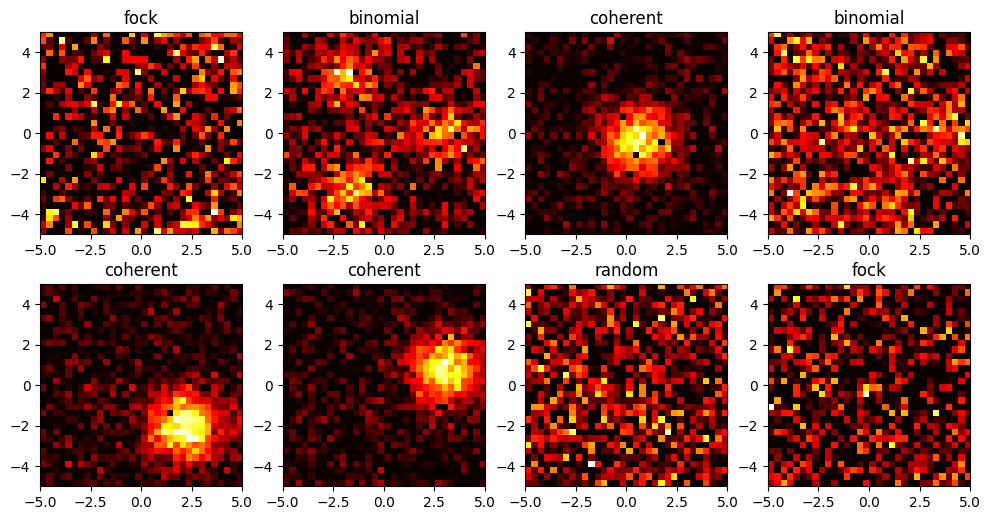

In [9]:
fig, axs = plt.subplots(2, 4, figsize=(12, 6))
axs[0,0].imshow(data['Husimi-Q_function'][0], extent=[-5,5,-5,5], cmap='hot')
axs[0,0].set_title(data['label'][0])
axs[0,1].imshow(data['Husimi-Q_function'][1], extent=[-5,5,-5,5], cmap='hot')
axs[0,1].set_title(data['label'][1])
axs[0,2].imshow(data['Husimi-Q_function'][2], extent=[-5,5,-5,5], cmap='hot')
axs[0,2].set_title(data['label'][2])
axs[0,3].imshow(data['Husimi-Q_function'][3], extent=[-5,5,-5,5], cmap='hot')
axs[0,3].set_title(data['label'][3])
axs[1,0].imshow(data['Husimi-Q_function'][4], extent=[-5,5,-5,5], cmap='hot')
axs[1,0].set_title(data['label'][4])
axs[1,1].imshow(data['Husimi-Q_function'][5], extent=[-5,5,-5,5], cmap='hot')
axs[1,1].set_title(data['label'][5])
axs[1,2].imshow(data['Husimi-Q_function'][6], extent=[-5,5,-5,5], cmap='hot')
axs[1,2].set_title(data['label'][6])
axs[1,3].imshow(data['Husimi-Q_function'][7], extent=[-5,5,-5,5], cmap='hot')
axs[1,3].set_title(data['label'][7])
plt.show()

## Modelling

Data preprocessing:

In [10]:
X = data['Husimi-Q_function']

y_class_raw = data['label']
label_encoder = LabelEncoder()
y_class_int = label_encoder.fit_transform(y_class_raw)

y_reg_real = data['state_parameter'].apply(lambda x: x.real)
y_reg_imag = data['state_parameter'].apply(lambda x: x.imag)
y_reg = np.array([y_reg_real, y_reg_imag]).T

X_train, X_test, y_train_class, y_test_class, y_train_reg, y_test_reg, indices_train, indices_test = train_test_split(X, y_class_int, y_reg, range(len(X)), test_size=0.2, random_state=42)

# Dictionaries to handle both regression and classification tasks
y_train = {"classification_output": y_train_class, "regression_output": y_train_reg}
y_test = {"classification_output": y_test_class, "regression_output": y_test_reg}
data_dim = X_train[0].shape[0]
X_train = np.array([x for x in X_train]).reshape(-1, data_dim, data_dim, 1)
X_test = np.array([x for x in X_test]).reshape(-1, data_dim, data_dim, 1)

We create an instance of the `qsttoolkit.tomography.MultitaskQuantumStateTomography` class, which handles the model architecture, compiling and training:

In [47]:
multitask_model = qst.tomography.MultitaskQuantumStateTomography(X_train=X_train,
                                                                 X_test=X_test,
                                                                 y_train=y_train,
                                                                 y_test=y_test,
                                                                 label_encoder=label_encoder,
                                                                 early_stopping_patience=30,
                                                                 lr_scheduler_factor=0.5,
                                                                 lr_scheduler_patience=15)

Model compiling and training using the `.train()` method:

In [48]:
multitask_model.train(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005, beta_1=0.9, beta_2=0.999),
                      classification_loss='sparse_categorical_crossentropy',
                      regression_loss='mse',
                      classification_loss_weight=1.0,
                      regression_loss_weight=1.0,
                      classification_metric='accuracy',
                      regression_metric='mse',
                      epochs=200,
                      batch_size=32,
                      validation_split=0.2,
                      verbose='auto')

Epoch 1/200
140/140 ━━━━━━━━━━━━━━━━━━━━ 18s 48ms/step - classification_output_accuracy: 0.1503 - classification_output_loss: 2.0782 - loss: 42.9792 - regression_output_loss: 40.9010 - regression_output_mse: 40.9010 - val_classification_output_accuracy: 0.2295 - val_classification_output_loss: 2.8761 - val_loss: 52.5859 - val_regression_output_loss: 49.7098 - val_regression_output_mse: 49.7098 - learning_rate: 5.0000e-04
Epoch 2/200
140/140 ━━━━━━━━━━━━━━━━━━━━ 14s 40ms/step - classification_output_accuracy: 0.3564 - classification_output_loss: 1.7332 - loss: 33.6287 - regression_output_loss: 31.8955 - regression_output_mse: 31.8955 - val_classification_output_accuracy: 0.2643 - val_classification_output_loss: 1.6855 - val_loss: 47.8238 - val_regression_output_loss: 46.1383 - val_regression_output_mse: 46.1383 - learning_rate: 5.0000e-04
Epoch 3/200
140/140 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step - classification_output_accuracy: 0.5199 - classification_output_loss: 1.2968 - loss: 29.6706 - 

## Analysis and Evaluation

Inspection of accuracy and loss over training epochs:

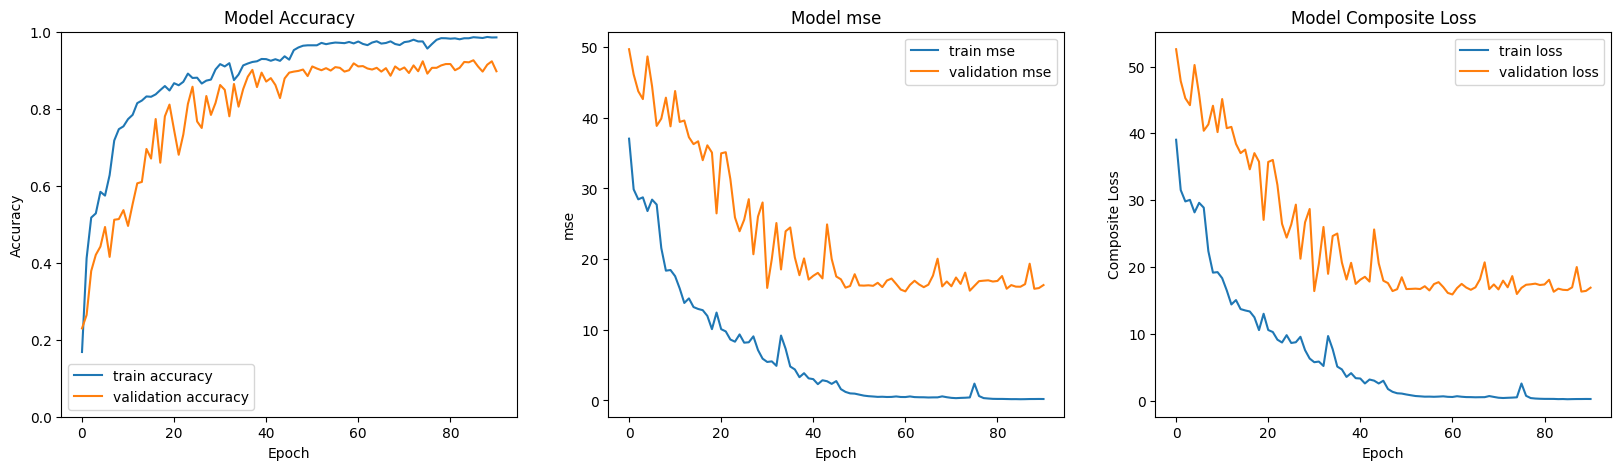

In [49]:
multitask_model.plot_training()

Model evaluation:

In [50]:
multitask_model.model.predict(X_test)[0].shape

44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step


(1400, 7)

44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step


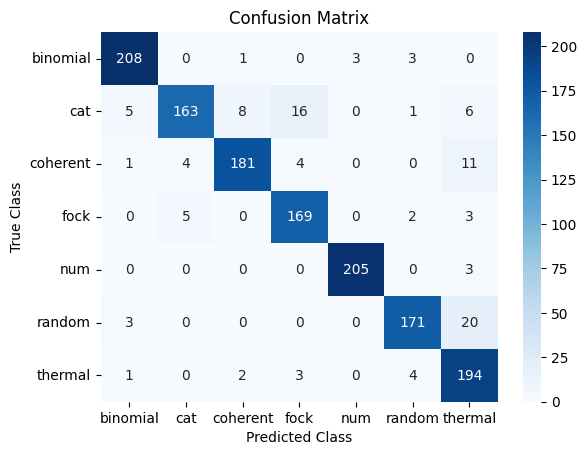

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.97      0.96       215
           1       0.95      0.82      0.88       199
           2       0.94      0.90      0.92       201
           3       0.88      0.94      0.91       179
           4       0.99      0.99      0.99       208
           5       0.94      0.88      0.91       194
           6       0.82      0.95      0.88       204

    accuracy                           0.92      1400
   macro avg       0.92      0.92      0.92      1400
weighted avg       0.93      0.92      0.92      1400



In [51]:
multitask_model.evaluate_classification(include_confusion_matrix=True, include_classification_report=True)

44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step


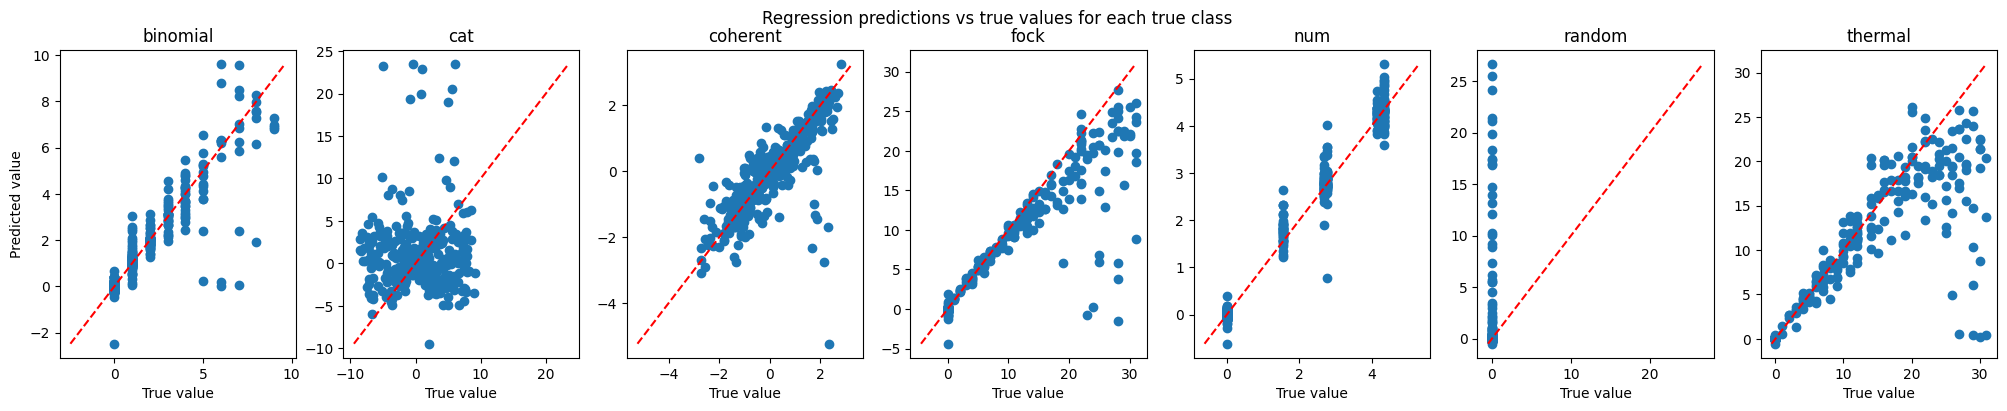

In [52]:
multitask_model.evaluate_regression()

Built-in `.infer()` method to infer labels and parameters for given input measurements and invert the label encoding, returning arrays of predicted label strings and parameter values:

In [53]:
print(multitask_model.infer(X_test))

44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
(array(['fock', 'fock', 'binomial', ..., 'num', 'cat', 'random'],
      dtype=object), [(3.2201220989227295+0.04224453493952751j), (12.258353233337402-0.037198785692453384j), (1.2637789249420166-0.06968560814857483j), (4.084875106811523+0.029369566589593887j), (0.16427499055862427+0.07816606760025024j), (-0.4008031189441681-1.304105281829834j), (16.982275009155273-0.008777324110269547j), (2.517771005630493-0.04247738793492317j), (2.8528685569763184+0.009186264127492905j), (-0.06999203562736511-1.136130690574646j), (2.6438770294189453-0.018725235015153885j), (0.981712818145752-1.1680201292037964j), (0.12572497129440308-0.06951391696929932j), (4.367823600769043+0.07268625497817993j), (0.373380571603775+4.2150983810424805j), (0.30491209030151367+0.6215075850486755j), (-0.17922624945640564-1.038994312286377j), (0.7656036615371704-0.25975847244262695j), (1.7254056930541992-0.016307134181261063j), (0.03072679042816162-0.05079955235123634j), (3.61965894

`MultitaskQuantumStateTomography.model` can be treated as a `tensorflow.keras.Model` object, for example:

In [54]:
multitask_model.model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 32, 32, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ feature_extractor   │ (None, 204800)    │  1,577,248 │ input_layer_4[0]… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_16 (Dense)    │ (None, 64)        │ 13,107,264 │ feature_extracto… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_34      │ (None, 64)        │          0 │ dense_16[0][0]    │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_11          │ (None, 64)        │          0 │ leaky_re_lu_34[0… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_17 (Dense)    │ (None, 128)       │      8,320 │ dropout_11[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_35      │ (None, 128)       │          0 │ dense_17[0][0]    │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ classification_out… │ (None, 7)         │        903 │ leaky_re_lu_35[0… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 204807)    │          0 │ feature_extracto… │
│ (Concatenate)       │                   │            │ classification_o… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_18 (Dense)    │ (None, 64)        │ 13,107,712 │ concatenate_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_36      │ (None, 64)        │          0 │ dense_18[0][0]    │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_19 (Dense)    │ (None, 128)       │      8,320 │ leaky_re_lu_36[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_37      │ (None, 128)       │          0 │ dense_19[0][0]    │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_20 (Dense)    │ (None, 256)       │     33,024 │ leaky_re_lu_37[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_38      │ (None, 256)       │          0 │ dense_20[0][0]    │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_21 (Dense)    │ (None, 256)       │     65,792 │ leaky_re_lu_38[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_39      │ (None, 256)       │          0 │ dense_21[0][0]    │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_22 (Dense)    │ (None, 256)       │     65,792 │ leaky_re_lu_39[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_40      │ (None, 256)       │          0 │ dense_22[0][0]    │
│ (LeakyReLU)         │                   │            │                 

 Total params: 84,022,589 (320.52 MB)

 Trainable params: 28,007,529 (106.84 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 56,015,060 (213.68 MB)

## Reconstructing Density Matrices from Inferred Labels and Parameters

QSTToolkit provides the `StateReconstructor` class which takes lists of inferred state labels and parameters and reconstructs the corresponding density matrices using QuTiP functions:

In [55]:
reconstructor = qst.tomography.StateReconstructor()

predicted_labels, predicted_state_parameters = multitask_model.infer(X_test)

reconstructor.add_data(true_labels = label_encoder.inverse_transform(y_test['classification_output']),
                       predicted_labels = predicted_labels,
                       true_state_parameters = y_test['regression_output'],
                       predicted_state_parameters = predicted_state_parameters,
                       true_dms = data['density_matrix'].iloc[indices_test].reset_index(drop=True))

44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step


In [56]:
reconstructor.restrict_parameters(fock_n_range=[0,31], binomial_S_range=[1,10])

In [57]:
reconstructor.predictions_df.head()

,true_label,predicted_label,true_state_parameter,predicted_state_parameter,restricted_predicted_state_parameter,true_dm,reconstructed_dm,fidelity
0,fock,fock,4.000000,3.220122+ 0.042245j,3.000000+ 0.000000j,[[(0.005158886081517779+1.9493752637157556e-20...,NaN,NaN
1,fock,fock,15.000000,12.258353- 0.037199j,12.000000+ 0.000000j,[[(0.005083265745886623-6.106298334591572e-21j...,NaN,NaN
2,binomial,binomial,1.000000,1.263779- 0.069686j,1.000000+ 0.000000j,[[(0.12212518494665543+4.1009172947457305e-20j...,NaN,NaN
3,num,num,4.149065,4.084875+ 0.029370j,4.149065+ 0.000000j,[[(0.005149887938772308+1.0554204007469665e-20...,NaN,NaN
4,cat,thermal,-0.085594,0.164275+ 0.078166j,0.164275+ 0.078166j,"[[(0.767110237556656-2.7768748784433807e-20j),...",NaN,NaN


In [58]:
reconstructor.reconstruct()

In [59]:
reconstructor.predictions_df.head()

,true_label,predicted_label,true_state_parameter,predicted_state_parameter,restricted_predicted_state_parameter,true_dm,reconstructed_dm,fidelity
0,fock,fock,4.000000,3.220122+ 0.042245j,3.000000+ 0.000000j,[[(0.005158886081517779+1.9493752637157556e-20...,"Quantum object: dims=[[32], [32]], shape=(32, ...",NaN
1,fock,fock,15.000000,12.258353- 0.037199j,12.000000+ 0.000000j,[[(0.005083265745886623-6.106298334591572e-21j...,"Quantum object: dims=[[32], [32]], shape=(32, ...",NaN
2,binomial,binomial,1.000000,1.263779- 0.069686j,1.000000+ 0.000000j,[[(0.12212518494665543+4.1009172947457305e-20j...,"Quantum object: dims=[[32], [32]], shape=(32, ...",NaN
3,num,num,4.149065,4.084875+ 0.029370j,4.149065+ 0.000000j,[[(0.005149887938772308+1.0554204007469665e-20...,"Quantum object: dims=[[32], [32]], shape=(32, ...",NaN
4,cat,thermal,-0.085594,0.164275+ 0.078166j,0.164275+ 0.078166j,"[[(0.767110237556656-2.7768748784433807e-20j),...","Quantum object: dims=[[32], [32]], shape=(32, ...",NaN


Inspect accuracy of reconstructed states:

In [60]:
reconstructor.calculate_fidelities()

Failed to find a square root.
Failed to find a square root.
Failed to find a square root.
Failed to find a square root.
Failed to find a square root.
Failed to find a square root.
Failed to find a square root.
Failed to find a square root.
Failed to find a square root.
Failed to find a square root.
Failed to find a square root.
Failed to find a square root.
Failed to find a square root.
Failed to find a square root.
Failed to find a square root.
Failed to find a square root.
Failed to find a square root.
Failed to find a square root.
Failed to find a square root.
Failed to find a square root.
Failed to find a square root.
Failed to find a square root.
Failed to find a square root.
Failed to find a square root.
Failed to find a square root.
Failed to find a square root.


In [61]:
reconstructor.predictions_df.fidelity.mean()

np.longdouble('0.4743535661827157948')

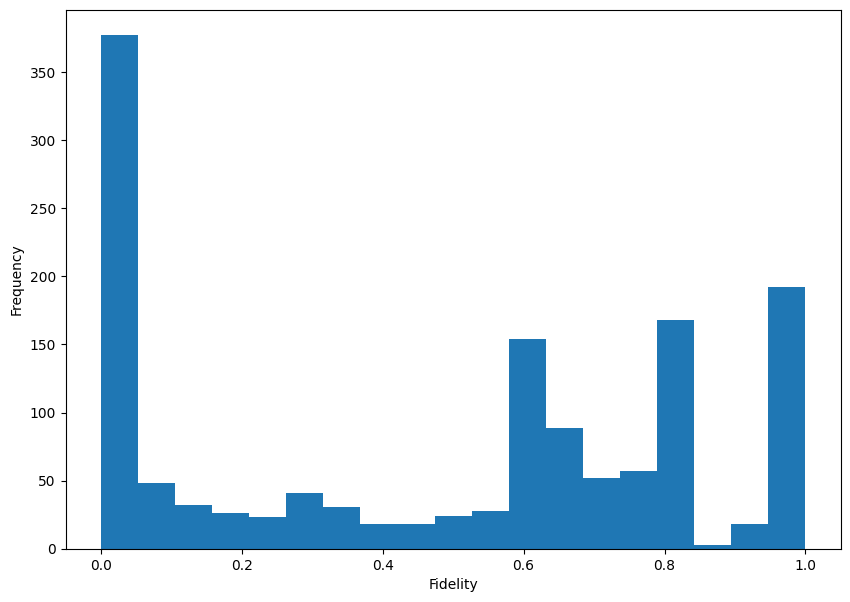

In [62]:
reconstructor.plot_fidelities(color_by_true_label=False)

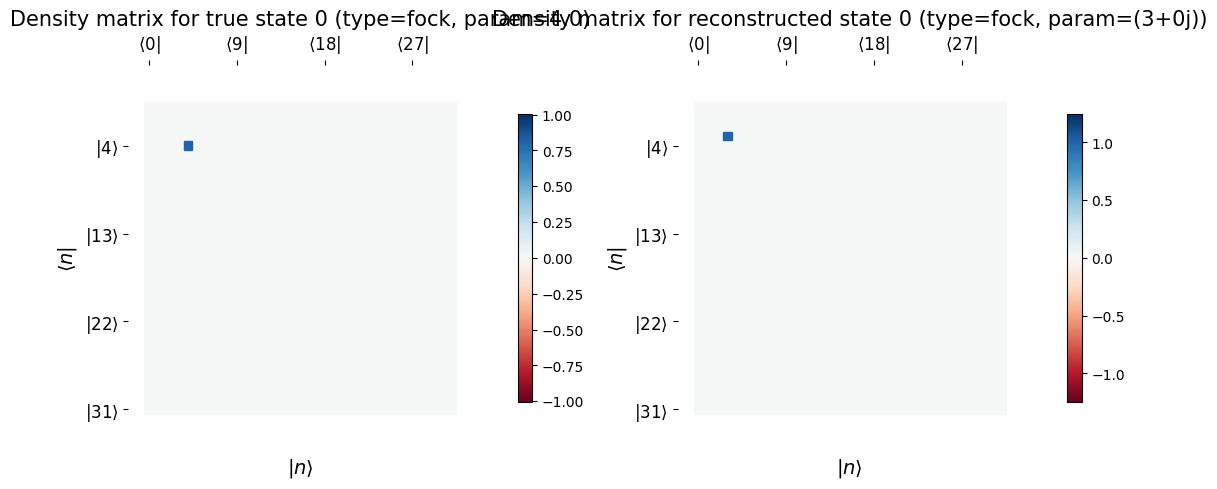

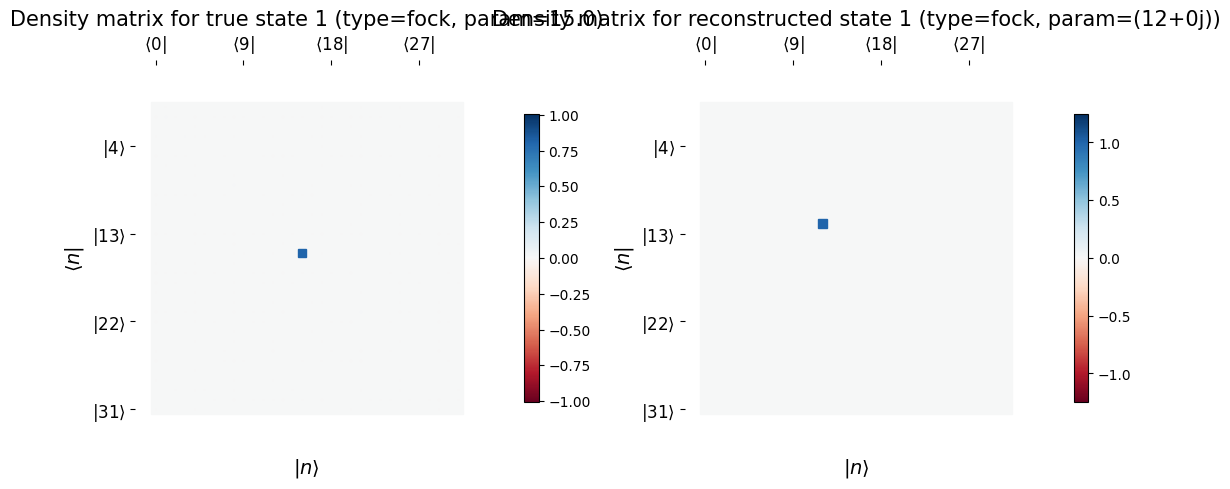

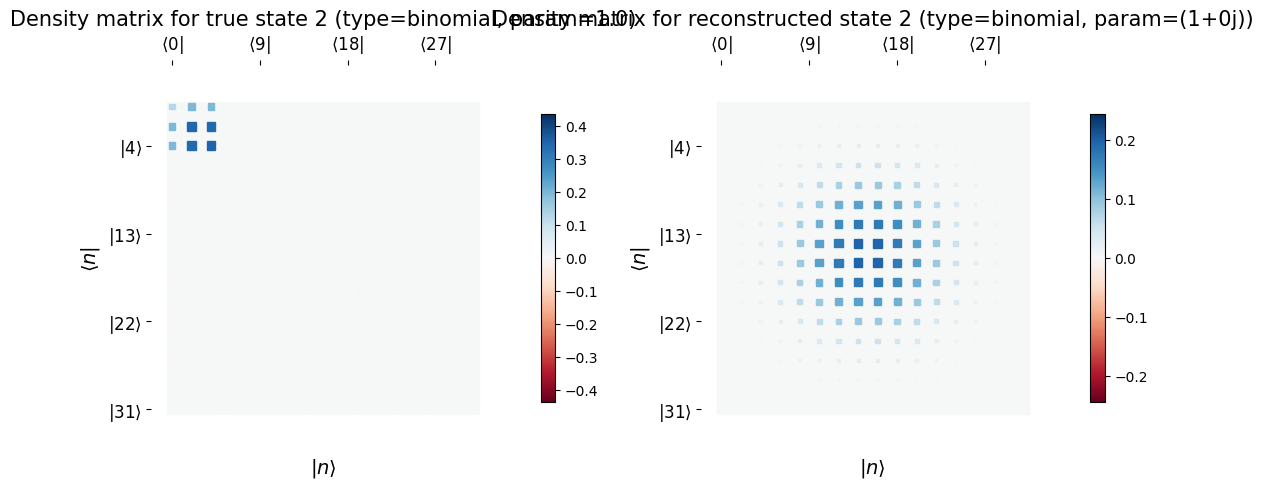

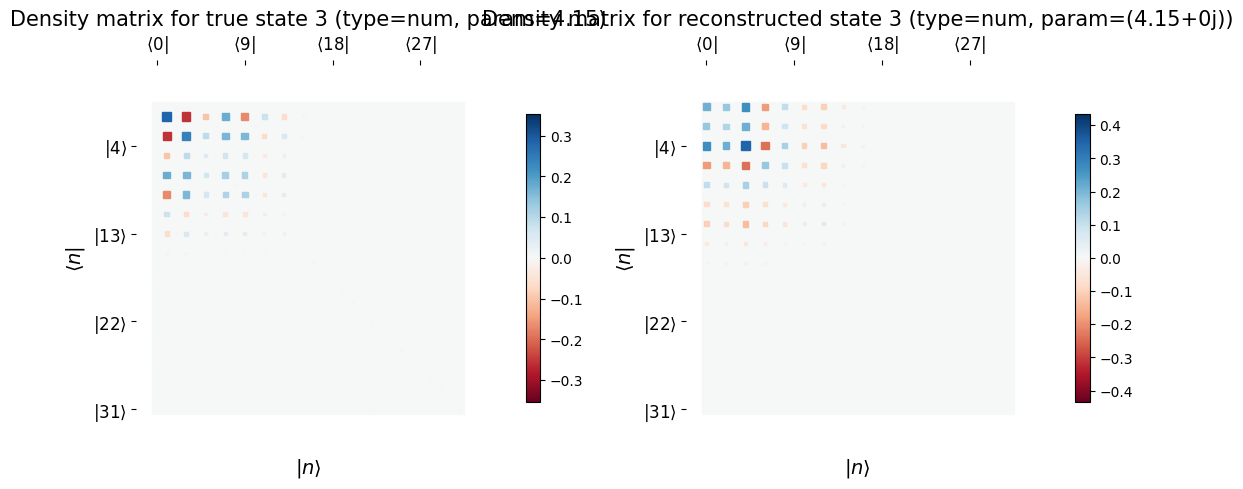

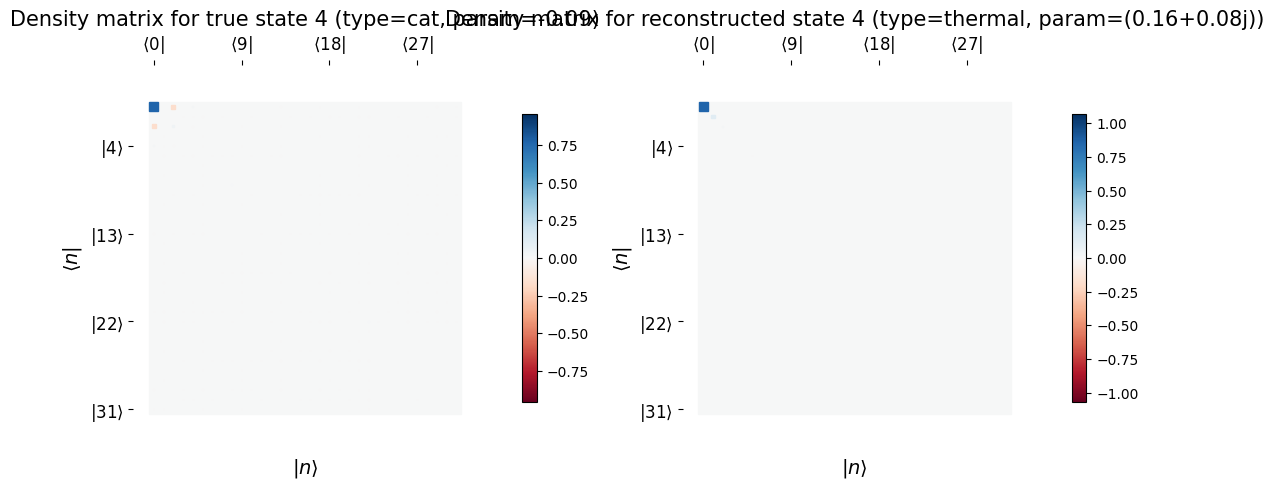

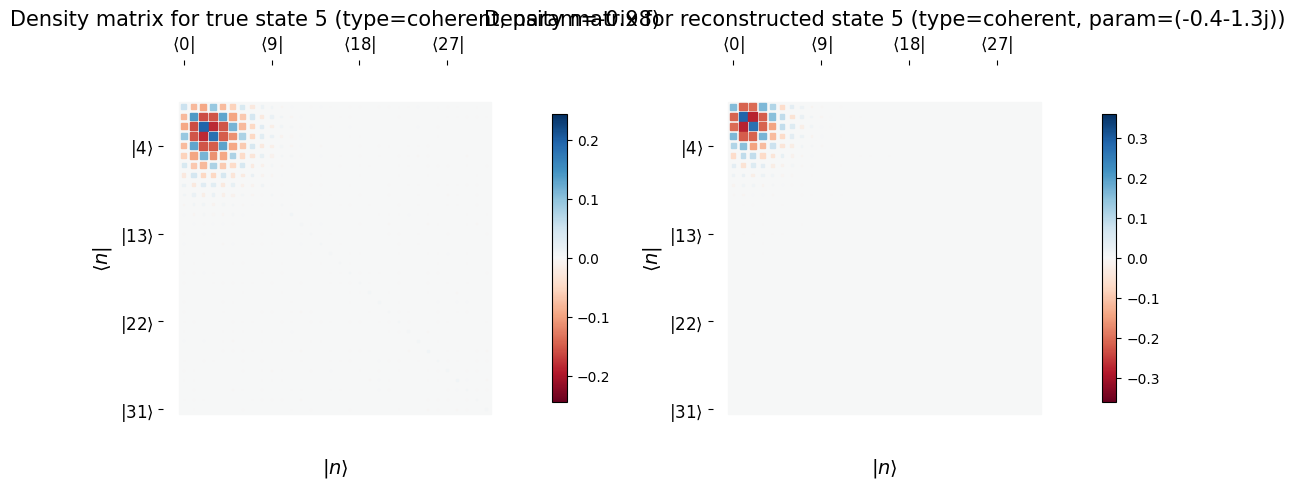

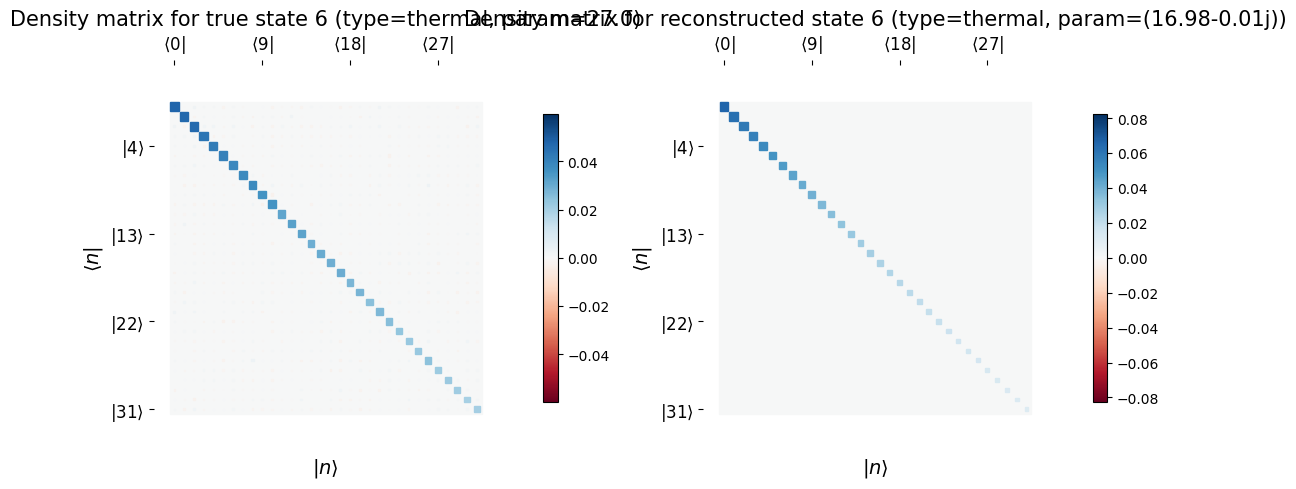

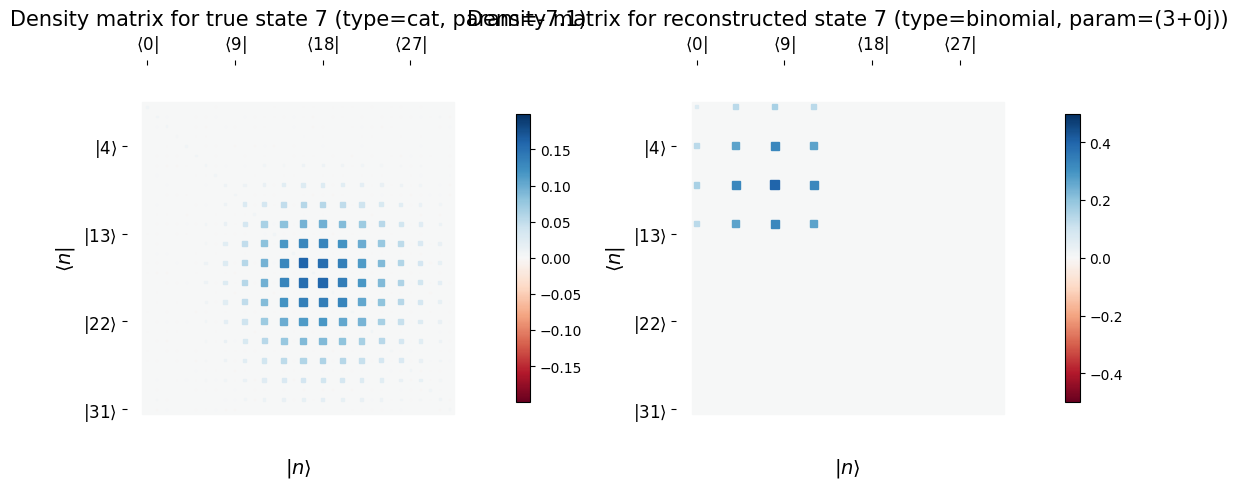

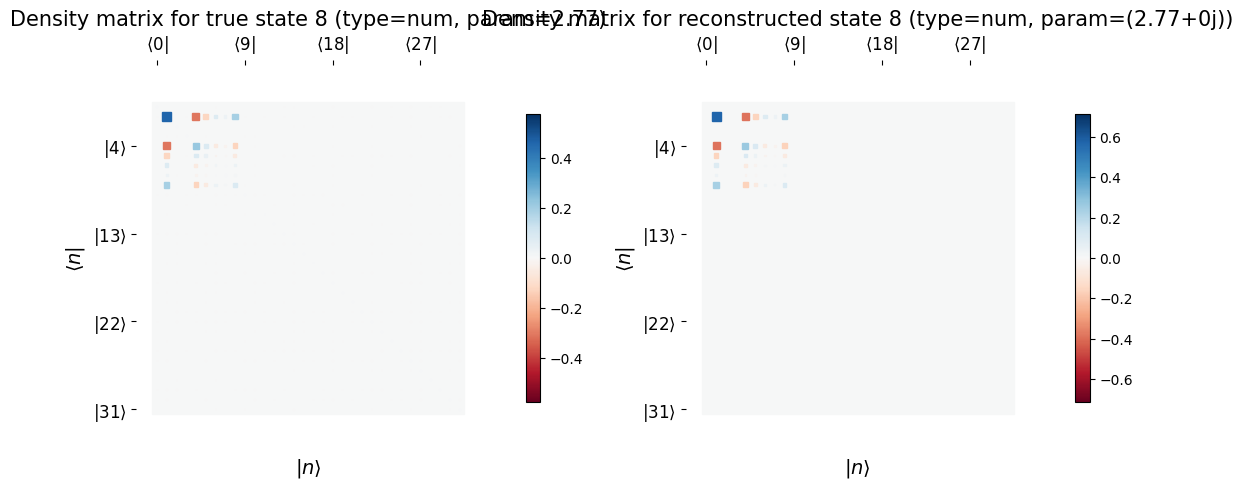

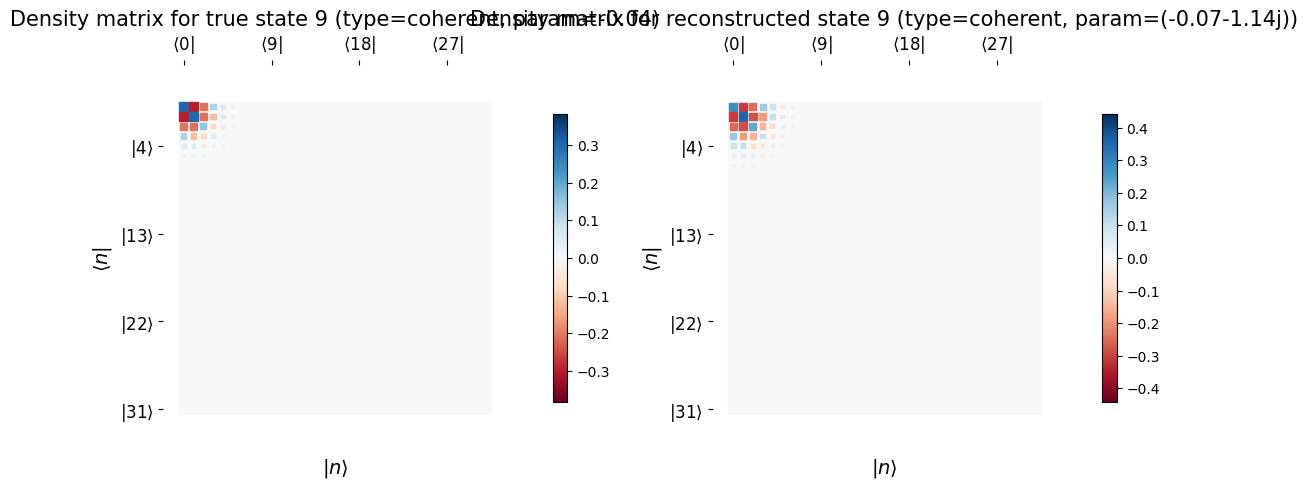

In [63]:
reconstructor.plot_comparison_Hintons([0,10])

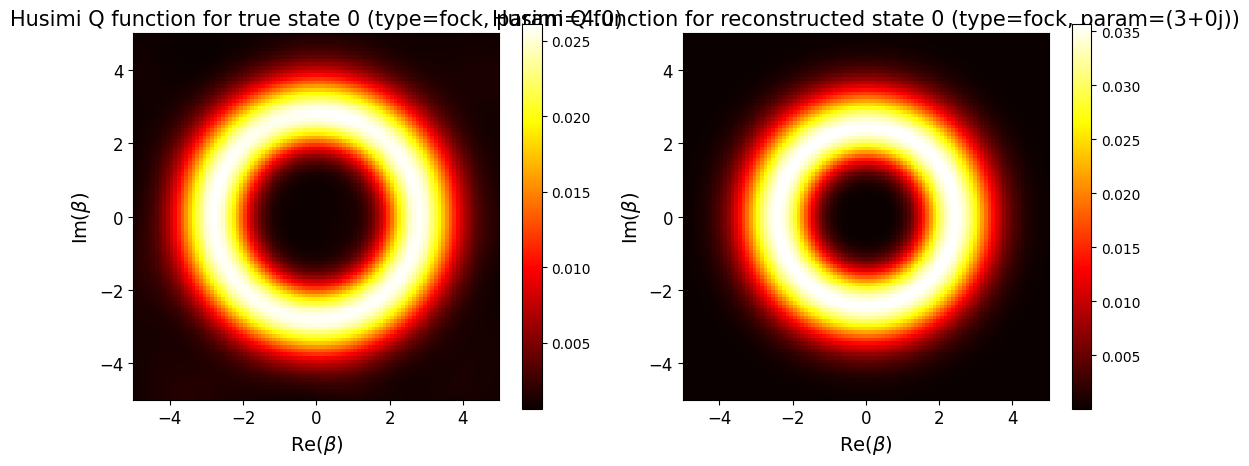

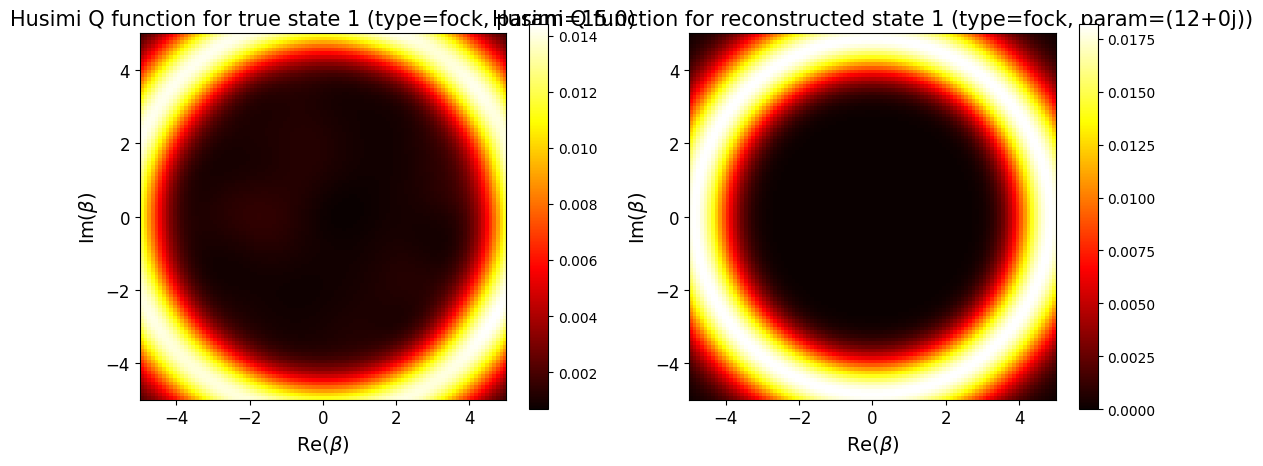

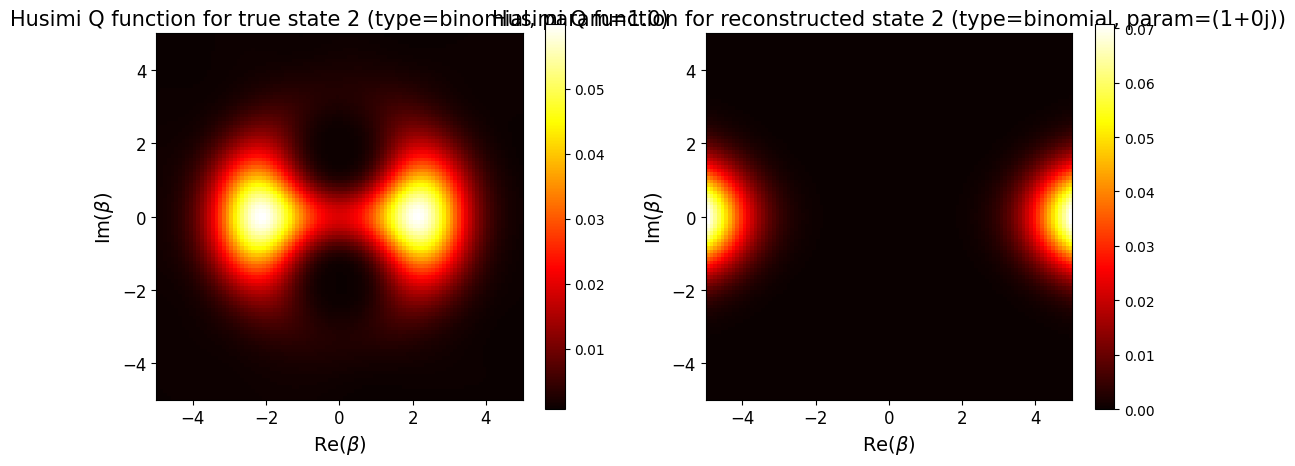

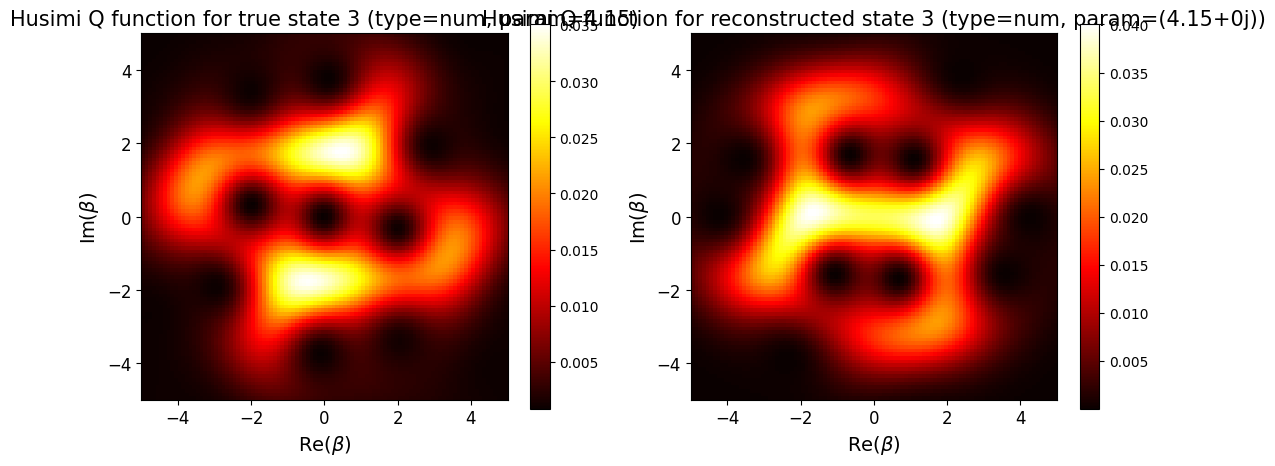

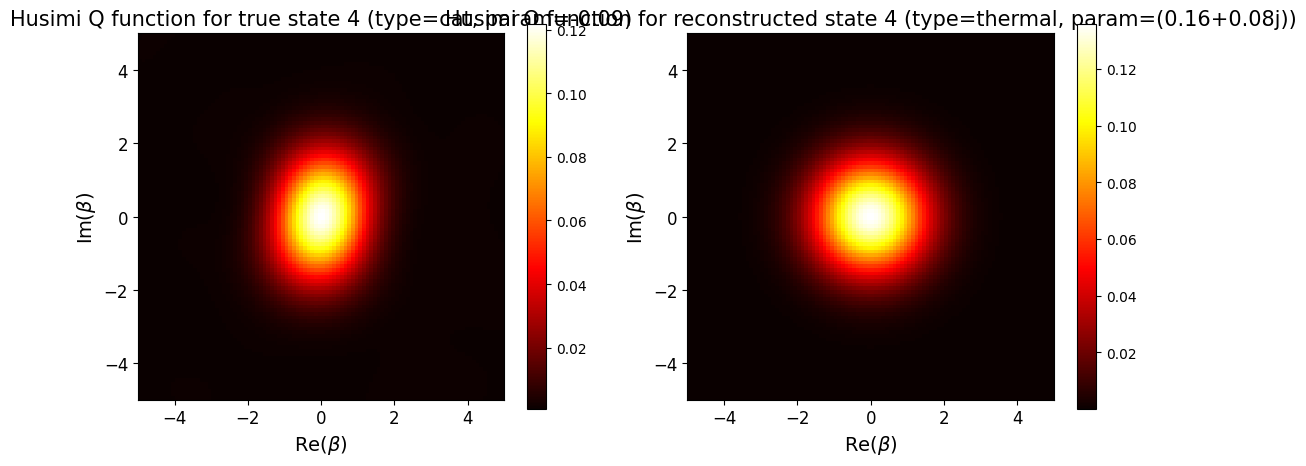

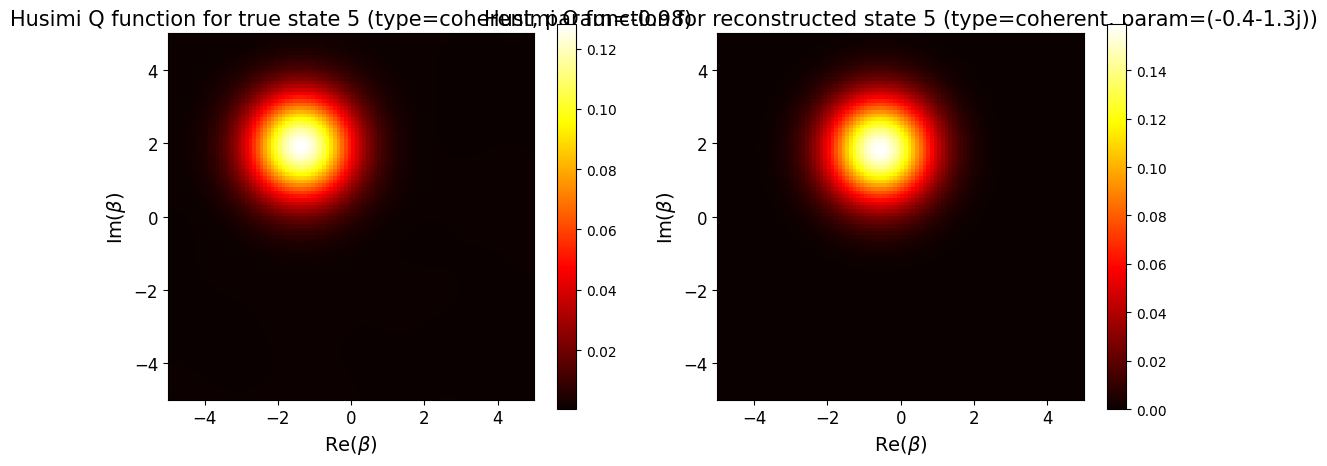

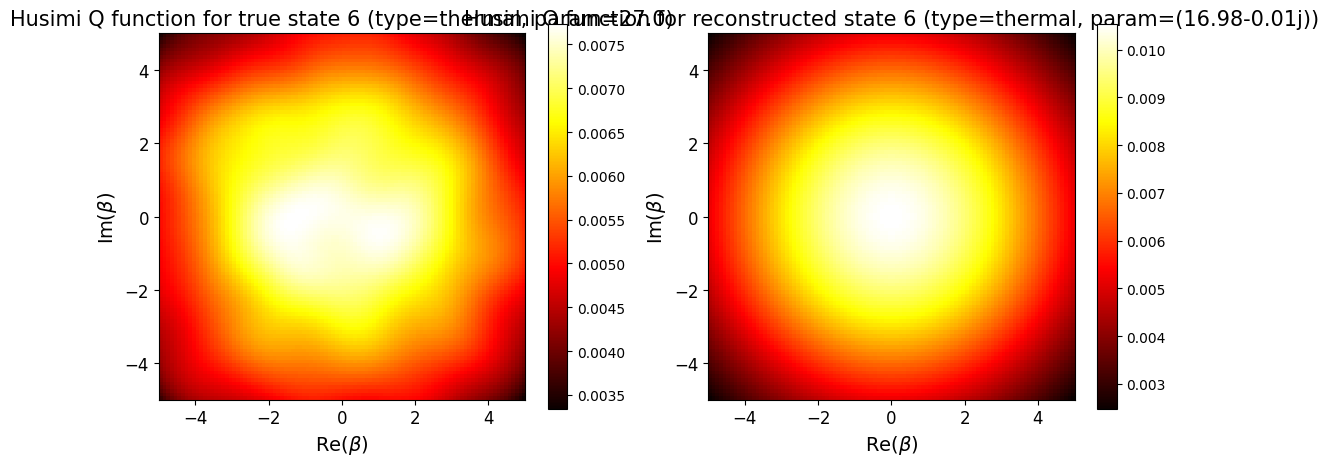

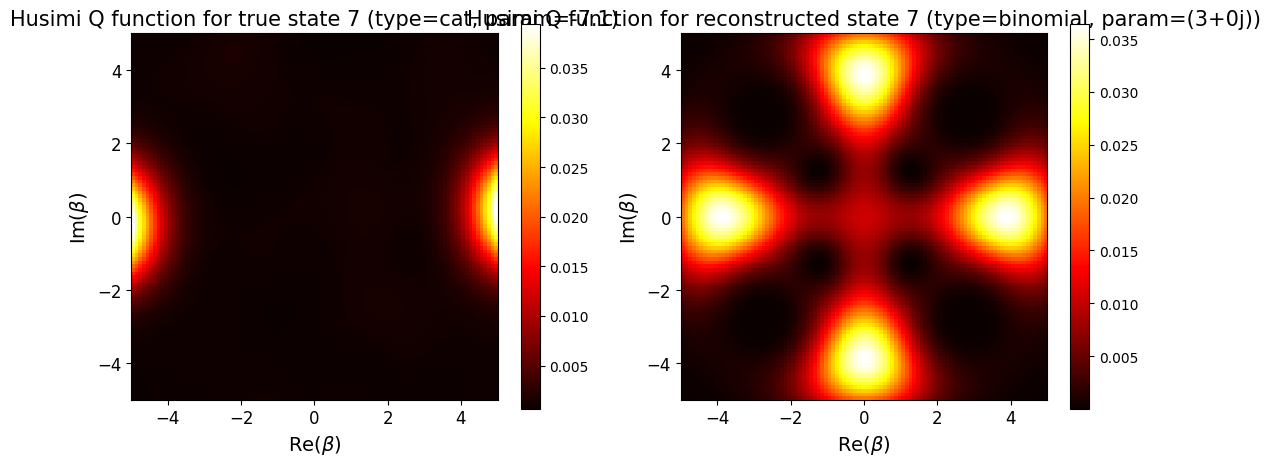

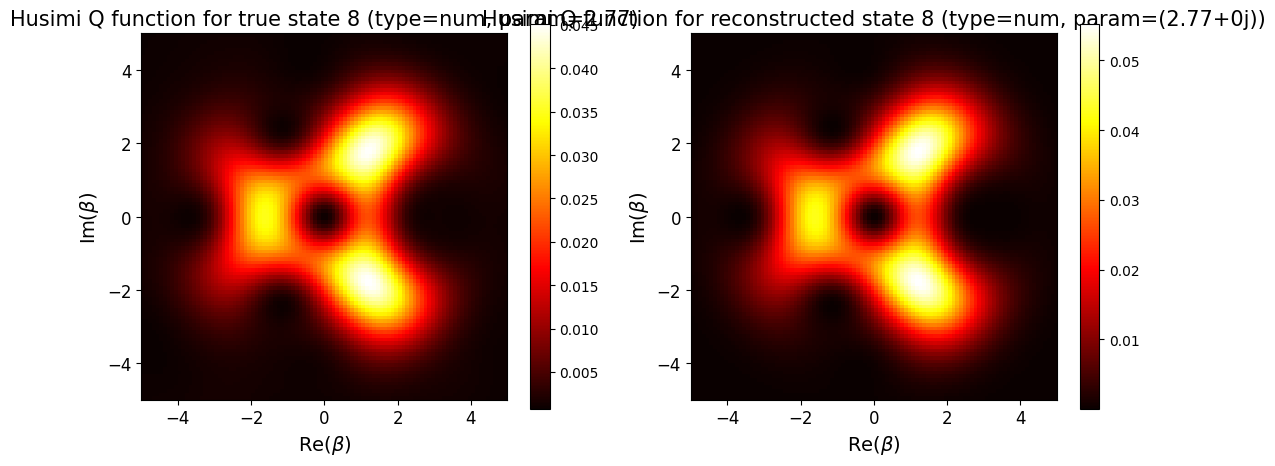

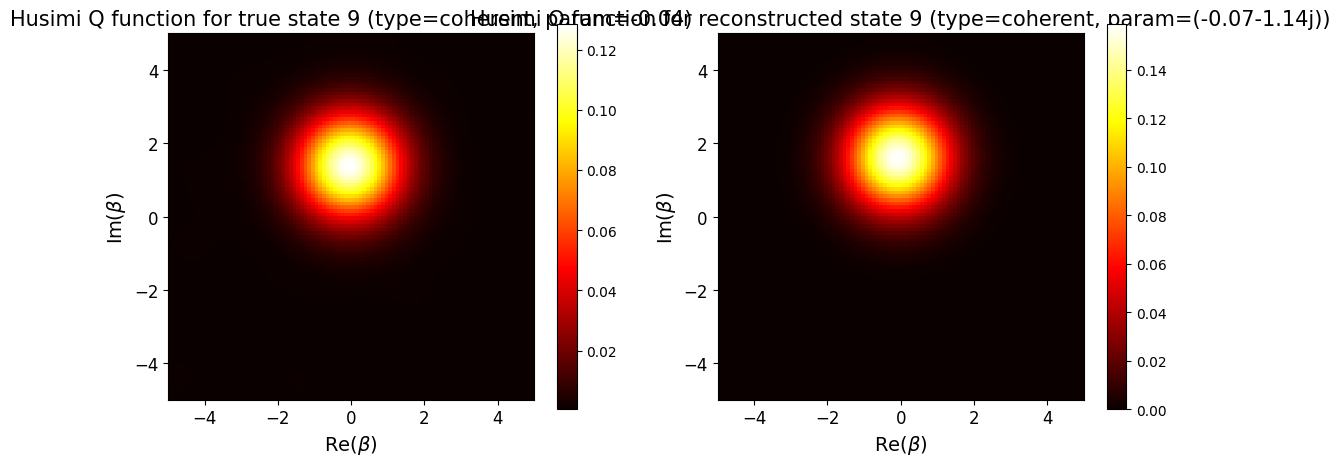

In [64]:
reconstructor.plot_comparison_Husimi_Qs([0,10])